In [ ]:
!pip install fcapy==0.1.4.1
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
!pip install bitarray

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 137 kB 6.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 7.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 241 kB 7.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 9.4 MB 8.3 MB/s 
Looking in i

In [ ]:
#!pip install bitarray
#!pip install bitsets

In [ ]:
from sparselinear import SparseLinear

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

In [ ]:
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

In [ ]:
import neural_lib as nl

# Pipeline

In [ ]:
df = pd.read_csv('/content/diabetes.csv')

In [ ]:
df.shape

(768, 9)

In [ ]:
df.sample()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
698,4,127,88,11,155,34.5,0.598,28,0


# Step 0. Binarize the data

In [ ]:
df_bin = pd.DataFrame()
#1
df_bin['BloodPressure>0'] = df['BloodPressure'] > 0
df_bin['BloodPressure=0'] = df['BloodPressure'] == 0
#2
df_bin['SkinThickness>0'] = df['SkinThickness'] > 0
df_bin['SkinThickness=0'] = df['SkinThickness'] == 0
#3
df_bin['BMI>0'] = df['BMI'] > 0
df_bin['BMI=0'] = df['BMI'] == 0


df_bin['Outcome'] = df['Outcome'] == 1

In [ ]:
df_bin['sample_id'] = np.arange(0, df_bin.shape[0], 1).astype(str)

In [ ]:
df_bin['id'] = df_bin['sample_id'].apply(lambda x: 'h' + x)

In [ ]:
df_bin.drop(columns=['sample_id'], inplace=True)

In [ ]:
df_bin=df_bin.set_index('id')

In [ ]:
df_bin.sample()

,BloodPressure>0,BloodPressure=0,SkinThickness>0,SkinThickness=0,BMI>0,BMI=0,Outcome
id,,,,,,,
h76,True,False,False,True,True,False,False


Split the data to train and test

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report

In [ ]:
y_feat = 'Outcome'
df_train, df_test = train_test_split(df_bin, train_size=0.7, random_state=0)

In [ ]:
df_test.sample()

,BloodPressure>0,BloodPressure=0,SkinThickness>0,SkinThickness=0,BMI>0,BMI=0,Outcome
id,,,,,,,
h375,True,False,True,False,True,False,True


In [ ]:
X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]

In [ ]:
X_train.sample()

,BloodPressure>0,BloodPressure=0,SkinThickness>0,SkinThickness=0,BMI>0,BMI=0
id,,,,,,
h23,True,False,True,False,True,False


## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [ ]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (537 objects, 6 attributes, 1611 connections)
    |BloodPressure>0|BloodPressure=0|SkinThickness>0|SkinThickness=0|BMI>0|BMI=0|
h580|              X|               |              X|               |    X|     |
h418|              X|               |               |              X|    X|     |
h764|              X|               |              X|               |    X|     |
h363|              X|               |               |              X|    X|     |
h757|              X|               |               |              X|    X|     |
h636|              X|               |               |              X|    X|     |
h155|              X|               |              X|               |    X|     |
h390|              X|               |              X|               |    X|     |
h761|              X|               |              X|               |    X|     |
h358|              X|               |              X|               |    X|     |
......................................

In [ ]:
%%time 
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

CPU times: user 80.5 ms, sys: 0 ns, total: 80.5 ms
Wall time: 82.6 ms


24

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [ ]:


for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)
    c.measures['recall_score'] = recall_score(y_train, y_preds)

In [ ]:
for c in L:
  print(c.measures['f1_score'], c.measures['recall_score'])

0.0 0.0
0.0099009900990099 0.005154639175257732
0.0821917808219178 0.04639175257731959
0.0900900900900901 0.05154639175257732
0.3227665706051873 0.28865979381443296
0.3218390804597701 0.28865979381443296
0.3275862068965517 0.29381443298969073
0.32664756446991405 0.29381443298969073
0.47750865051903113 0.711340206185567
0.4752136752136752 0.7164948453608248
0.48504983388704315 0.7525773195876289
0.48675496688741726 0.7577319587628866
0.5240793201133144 0.9536082474226805
0.5261669024045261 0.9587628865979382
0.520393811533052 0.9536082474226805
0.5224719101123596 0.9587628865979382
0.5338865836791148 0.9948453608247423
0.5331491712707181 0.9948453608247423
0.534435261707989 1.0
0.5302197802197802 0.9948453608247423
0.5294924554183814 0.9948453608247423
0.5287671232876713 0.9948453608247423
0.5315068493150685 1.0
0.53077975376197 1.0


Select indices of the best concepts from the lattice

In [ ]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:7])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [ ]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [ ]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

Move the nodes in visualization to make it look pretty

In [ ]:
'''
vis.init_mover_per_poset(cn.poset)
mvr = vis.mover
for a, b in [(11, 15), (2, 3), (2,8), (2, 4), (4,5), (24, 26), (22, 26), (23, 25), (22, 24), (6, 7), ]:
    mvr.swap_nodes(a, b)
    
for nodes, vert in [
    ([19, 18], 0), ([23, 22], 5), ([14, 21,20], 1), ([13, 24, 25], 6), ([26], 7), ([9, 15], 8)
]:
    for a in nodes:
        mvr.place_node(a, mvr.posx[vert])
'''

In [ ]:
set(df_test.columns)

{'BMI=0',
 'BMI>0',
 'BloodPressure=0',
 'BloodPressure>0',
 'Outcome',
 'SkinThickness=0',
 'SkinThickness>0'}

In [ ]:
descr = {'BMI=0', 'BMI>0'}

traced = cn.trace_description(descr, include_targets=False)

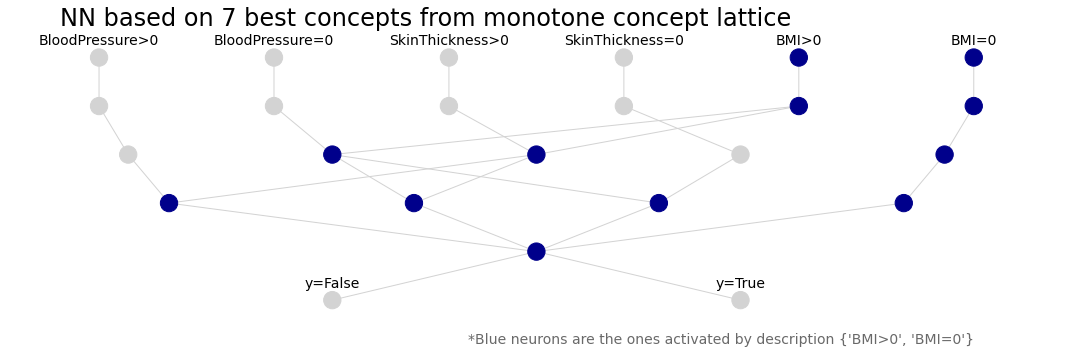

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))]
)
plt.title(f'NN based on 7 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('nn_silly_baseline.png')
plt.show()

Now fit the network

In [ ]:
cn.fit(X_train, y_train)

To obtain the prediction

In [ ]:
y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

Class prediction [0 0 0 0 0 0 0 0 0 0]
Class prediction with probabilities [[0.77725536 0.22274466]
 [0.77725536 0.22274466]
 [0.77725536 0.22274466]
 [0.77725536 0.22274466]
 [0.77725536 0.22274466]
 [0.77725536 0.22274466]
 [0.77725536 0.22274466]
 [0.77725536 0.22274466]
 [0.77725536 0.22274466]
 [0.77725536 0.22274466]]
True class [ True False False  True False False  True  True False False]


Check our metrics

In [ ]:
print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))

Recall score: 0.0
F1     score: 0.0


Let's also check accuracy and classification report

In [ ]:
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Accuracy score: 0.6796536796536796


In [ ]:
print(classification_report(y_test.values.astype('int'), y_pred))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81       157
           1       0.00      0.00      0.00        74

    accuracy                           0.68       231
   macro avg       0.34      0.50      0.40       231
weighted avg       0.46      0.68      0.55       231



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Let us look at the fitted weights of edges

In [ ]:
edge_weights = cn.edge_weights_from_network()

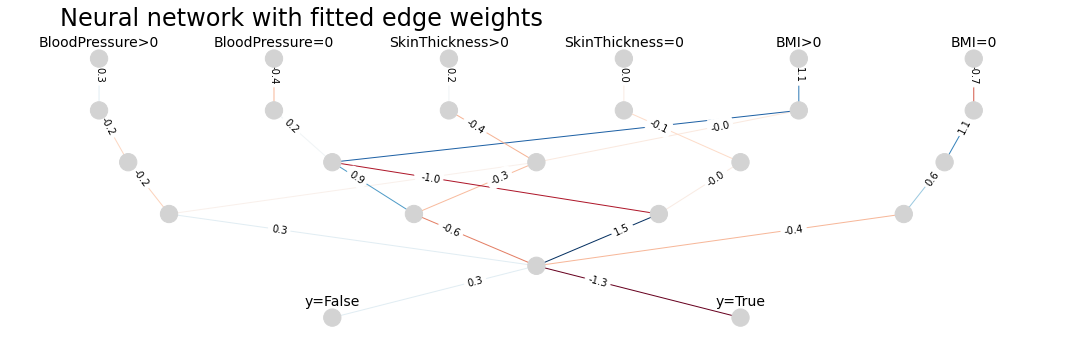

In [ ]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network_silly_baseline.png')
plt.show()